In [1]:
# 12-02 양방향 LSTM를 이용한 품사 태깅(Part-of-speech Tagging using Bi-LSTM)

import nltk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [2]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [3]:
# 토큰화에 품사 태깅이 된 데이터 받아오기
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences))


품사 태깅이 된 문장 개수:  3914


In [4]:
print(tagged_sentences[0])


[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [5]:
sentences, pos_tags = [], []
for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장한다.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장한다.

print("sentences=",sentences[0])
print("pos_tags=",pos_tags[0])


sentences= ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
pos_tags= ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


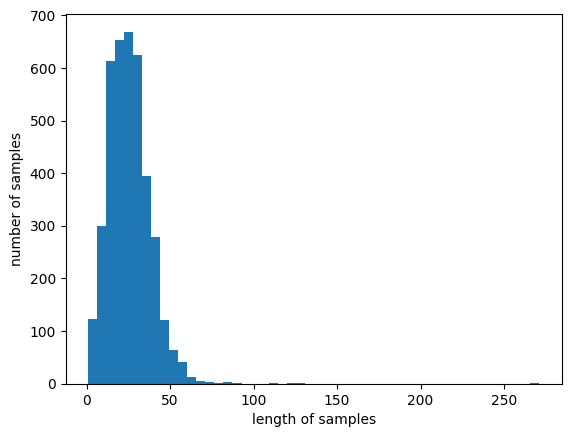

In [6]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [7]:
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer


In [8]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)


In [9]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))


단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [10]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)


In [11]:
print(X_train[:2])
print(y_train[:2])


[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [12]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))


훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=7, validation_data=(X_test, y_test))


Epoch 1/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.1517 - loss: 3.6055 - val_accuracy: 0.0452 - val_loss: 2.8195
Epoch 2/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.0581 - loss: 2.6325 - val_accuracy: 0.0824 - val_loss: 2.0347
Epoch 3/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.0861 - loss: 1.8600 - val_accuracy: 0.1074 - val_loss: 1.3777
Epoch 4/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.1176 - loss: 1.2270 - val_accuracy: 0.1379 - val_loss: 0.8410
Epoch 5/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.1462 - loss: 0.7108 - val_accuracy: 0.1497 - val_loss: 0.5318
Epoch 6/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.1573 - loss: 0.4156 - val_accuracy: 0.1550 - val_loss: 0.3820
Epoch 7/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.1619 - loss: 0.2626 - val_accuracy: 0.1575 - val_loss: 0.3088


In [14]:
model.save('20250714_강의복습_BiLSTM_Tagging.keras')

In [15]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.1580 - loss: 0.3079

 테스트 정확도: 0.1575


In [16]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측값 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 레이블로 변환.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], y_test[i], y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag].upper(), index_to_tag[pred].upper()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .
